# Lesson 2 : LangGraph Components

From Previous Lesson , We studied Following things :

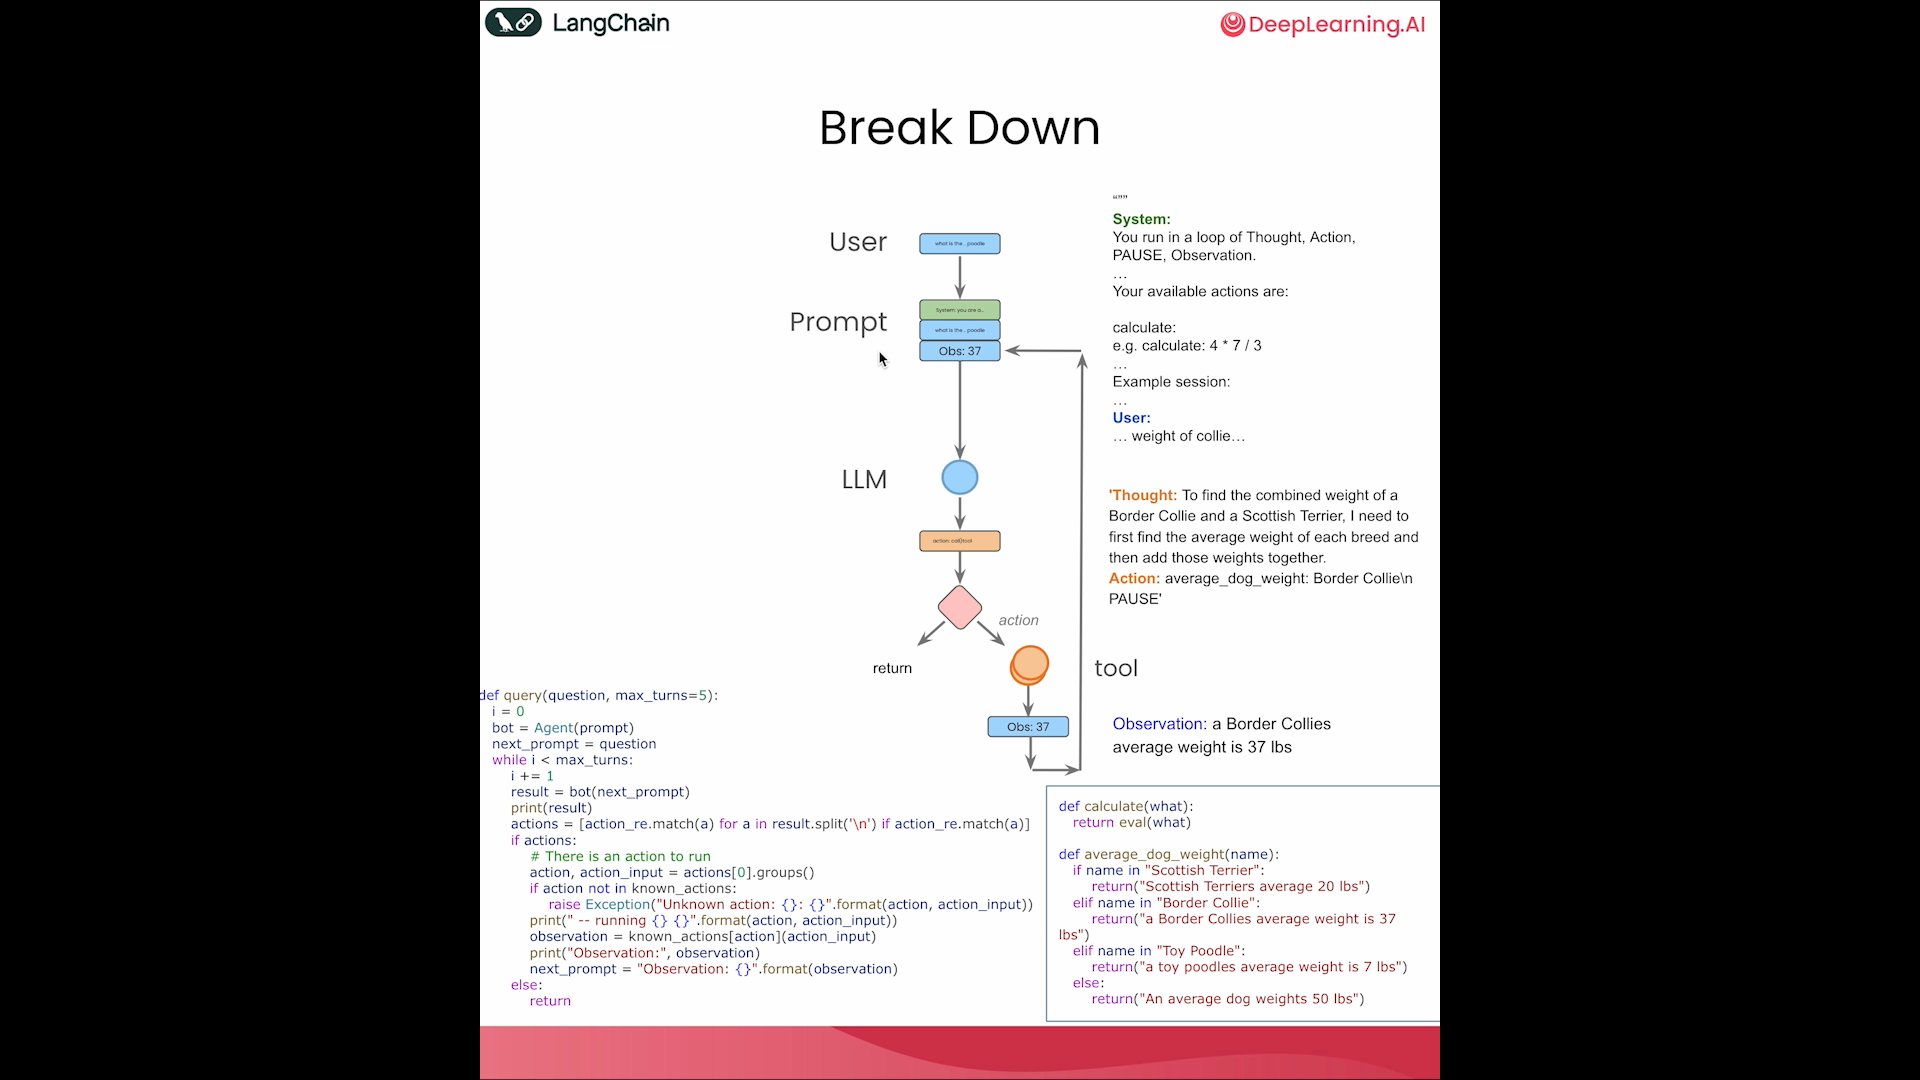

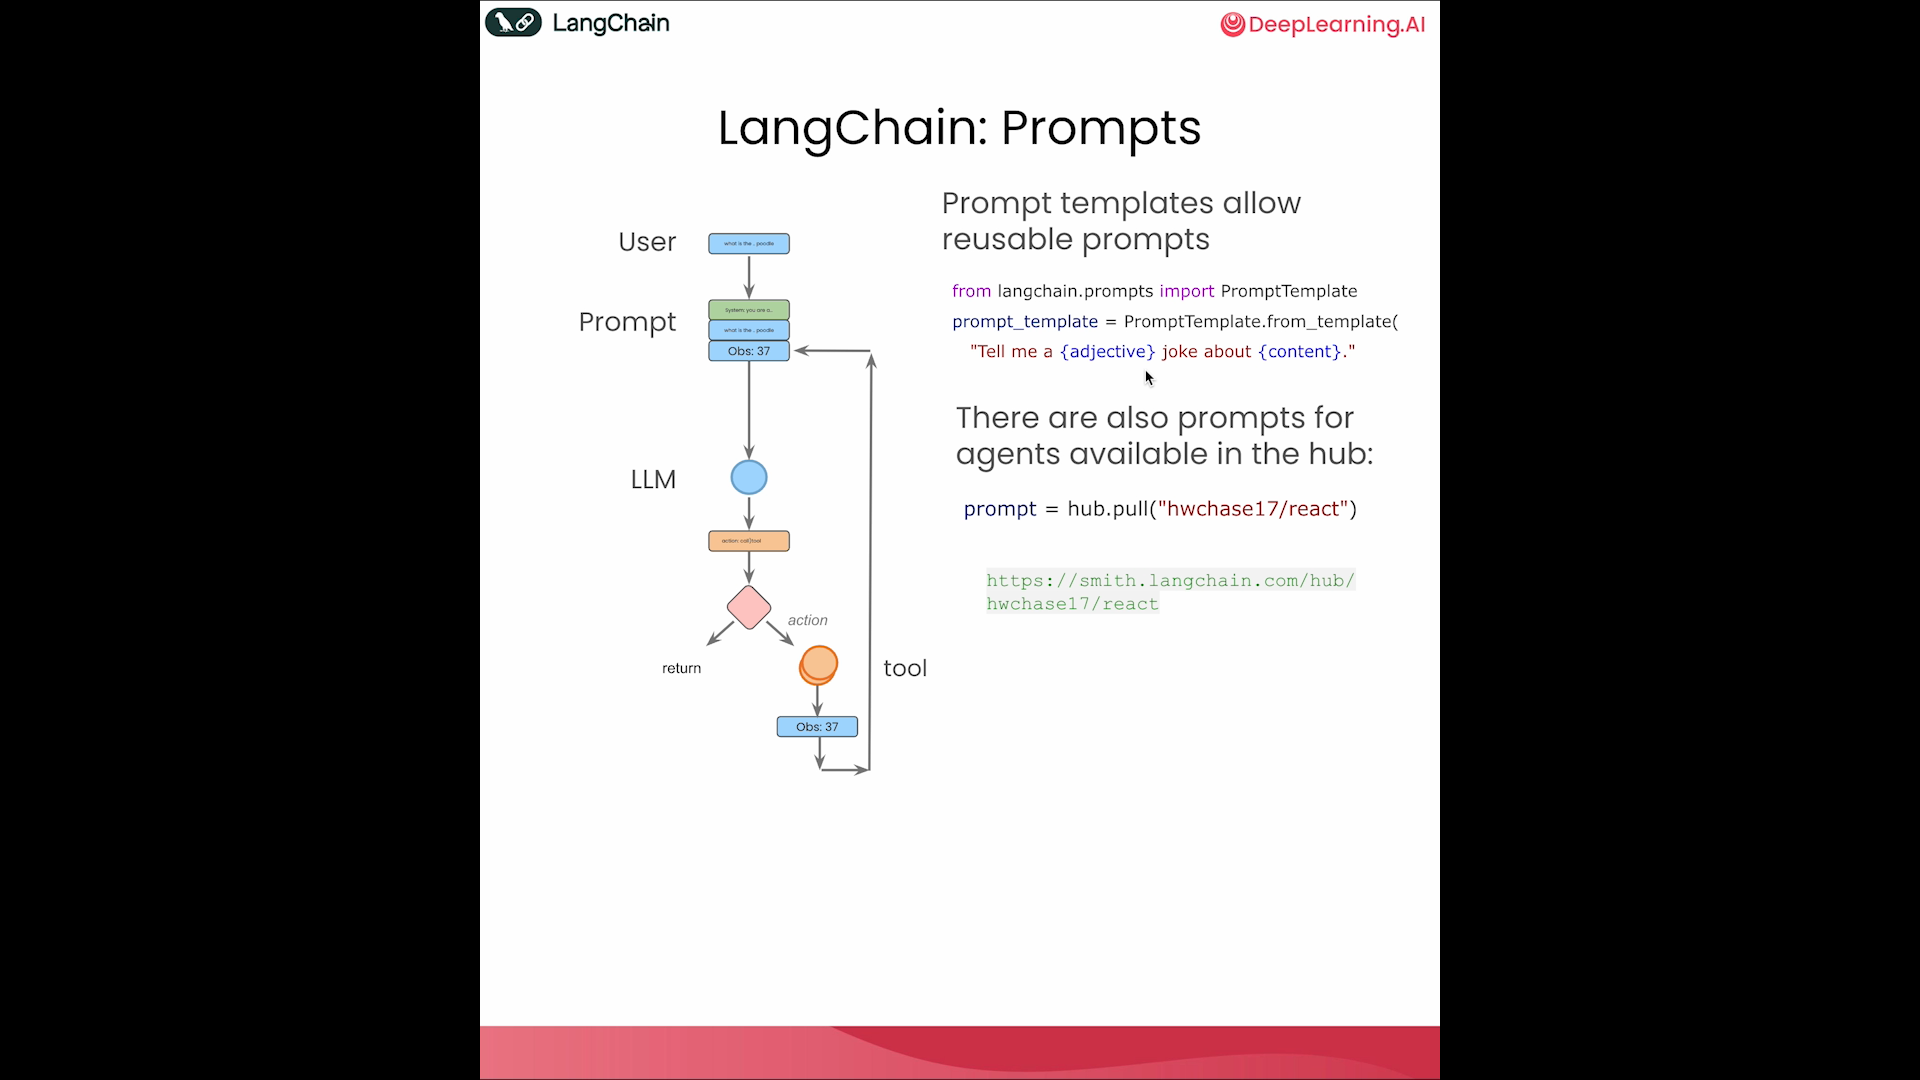

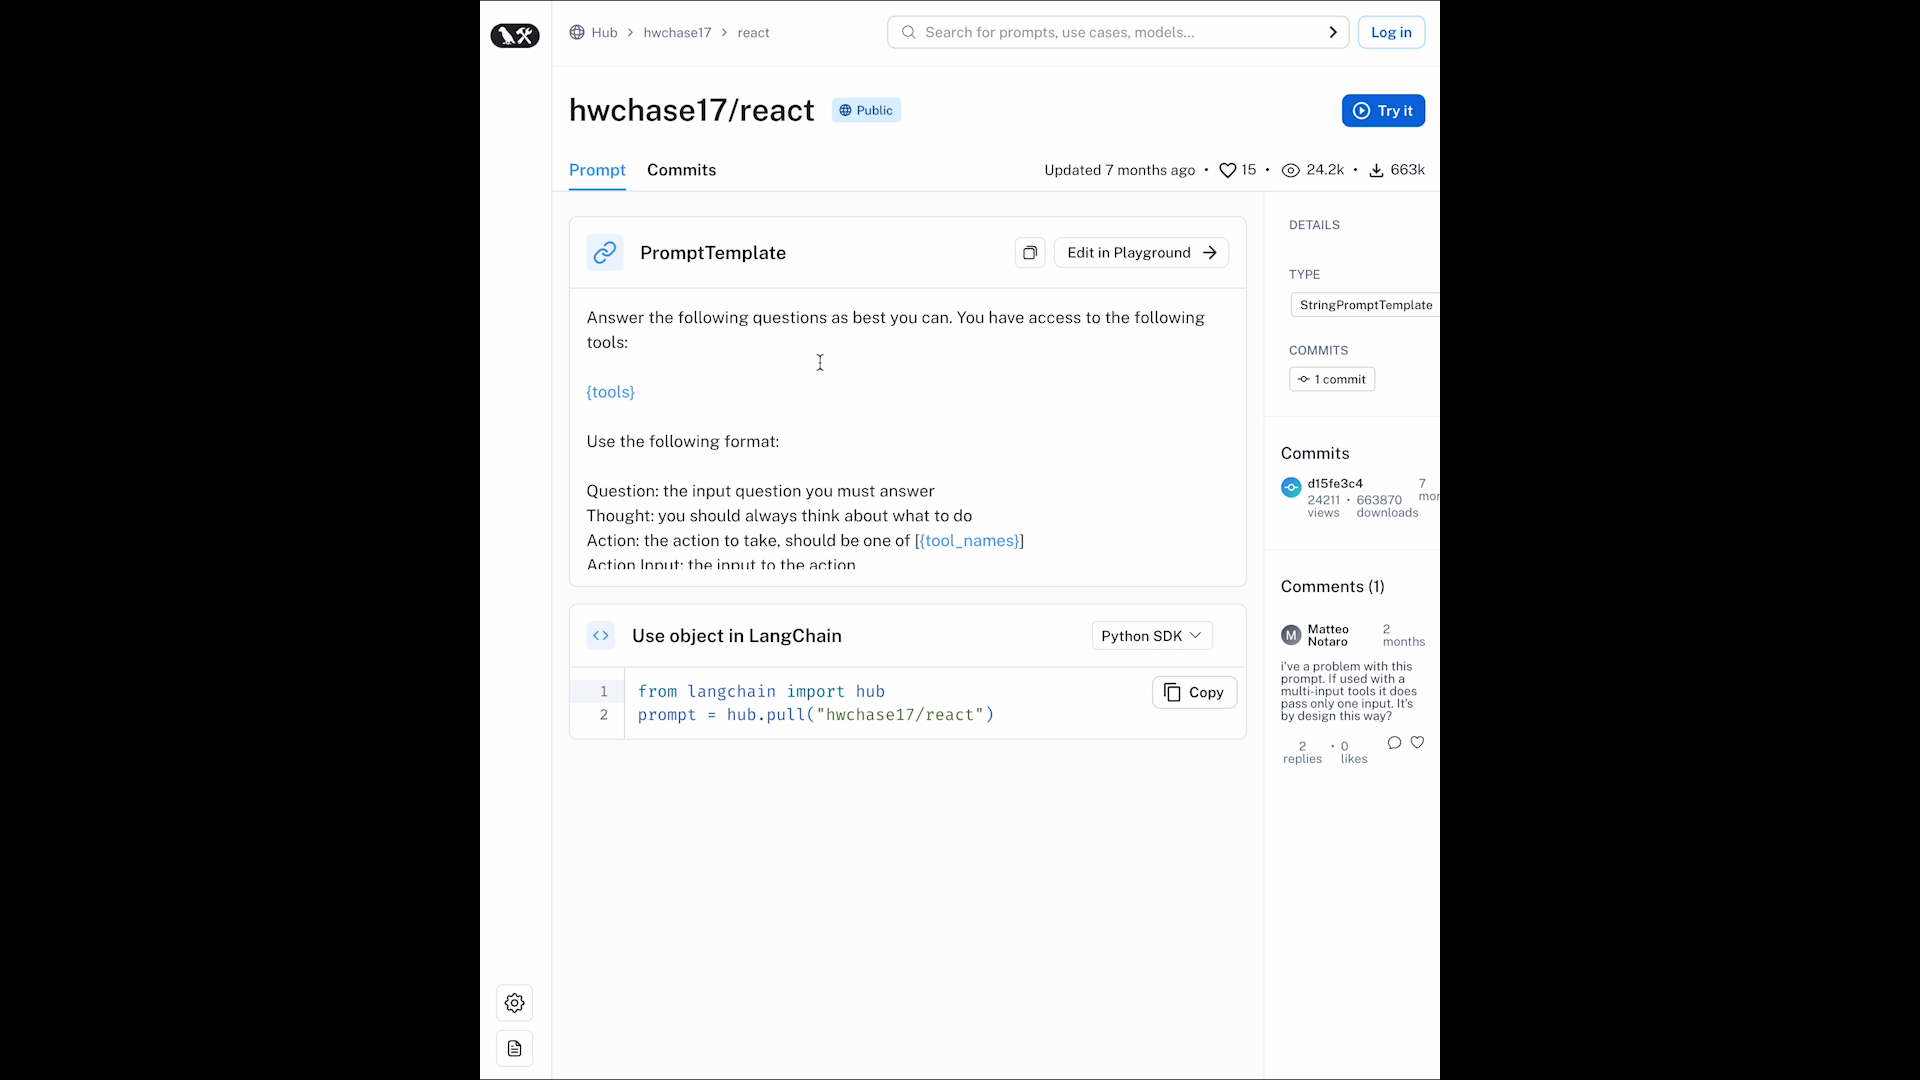

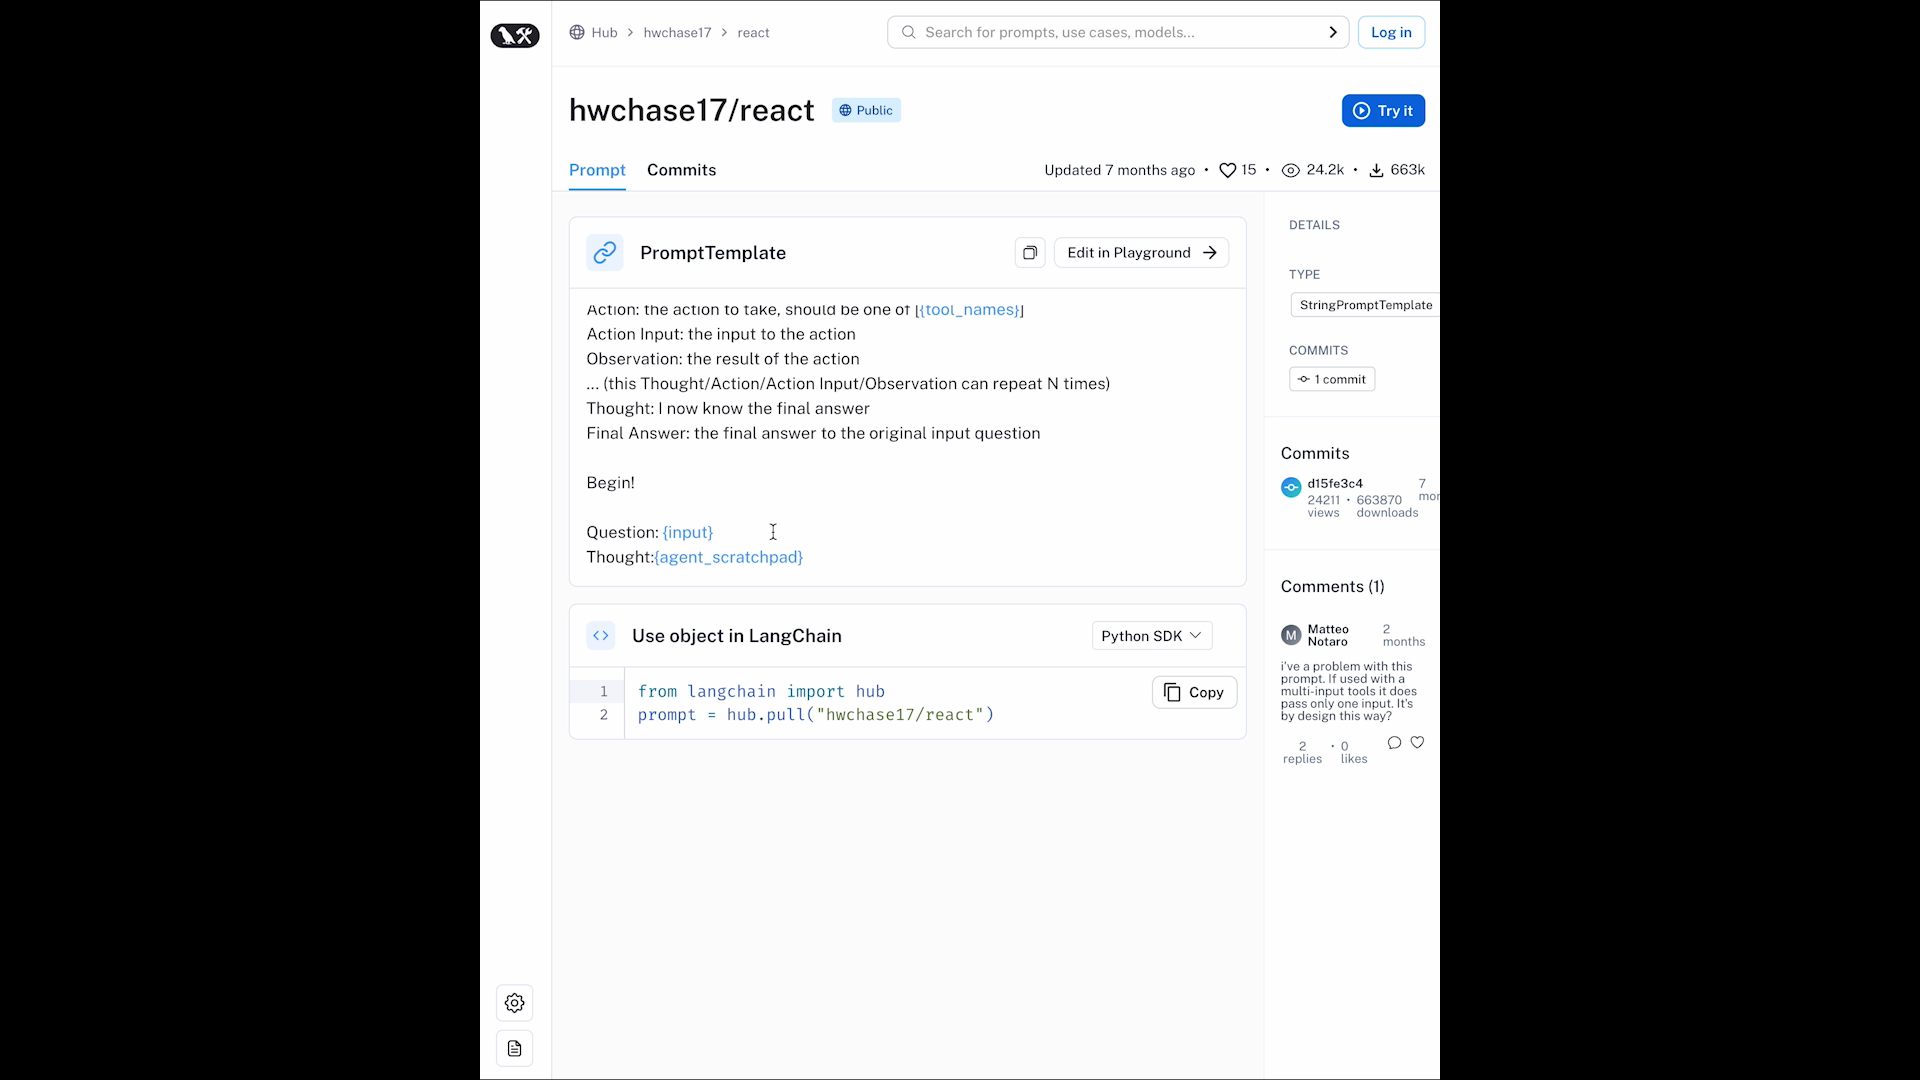

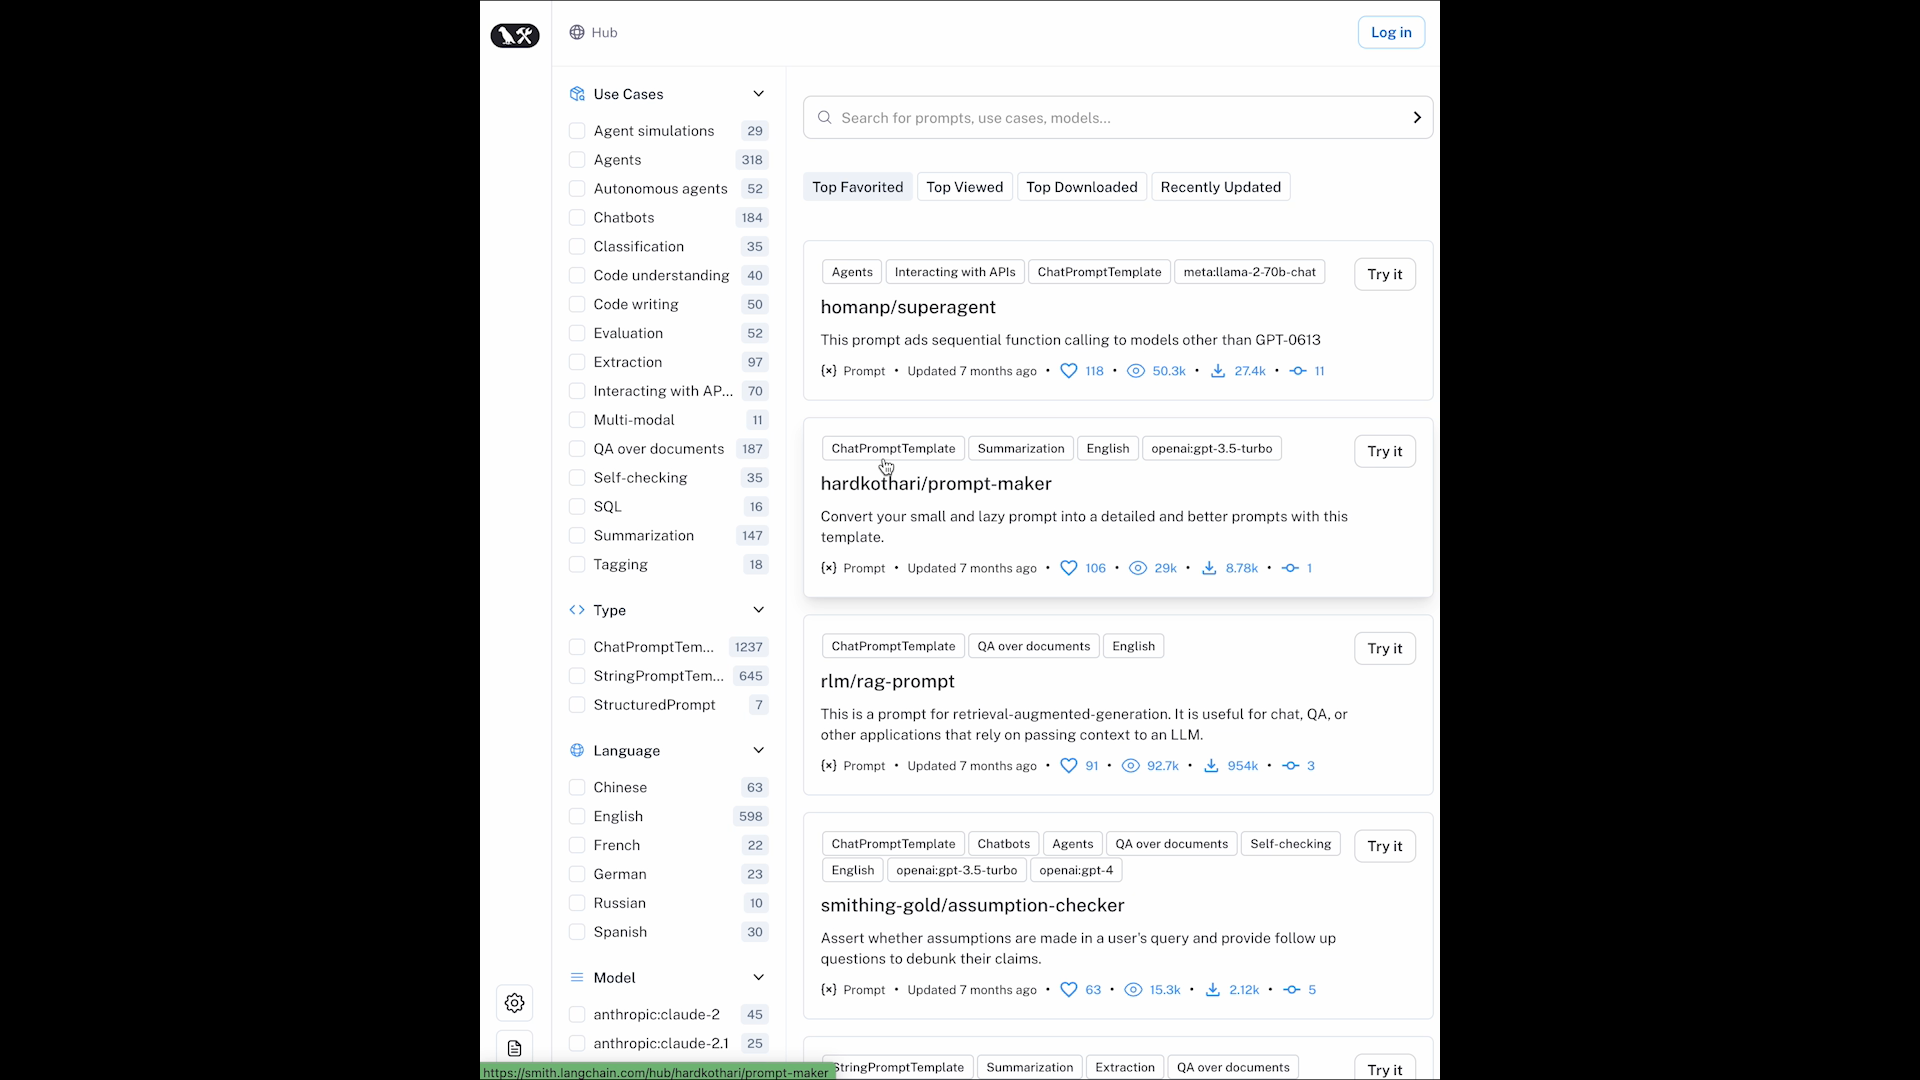

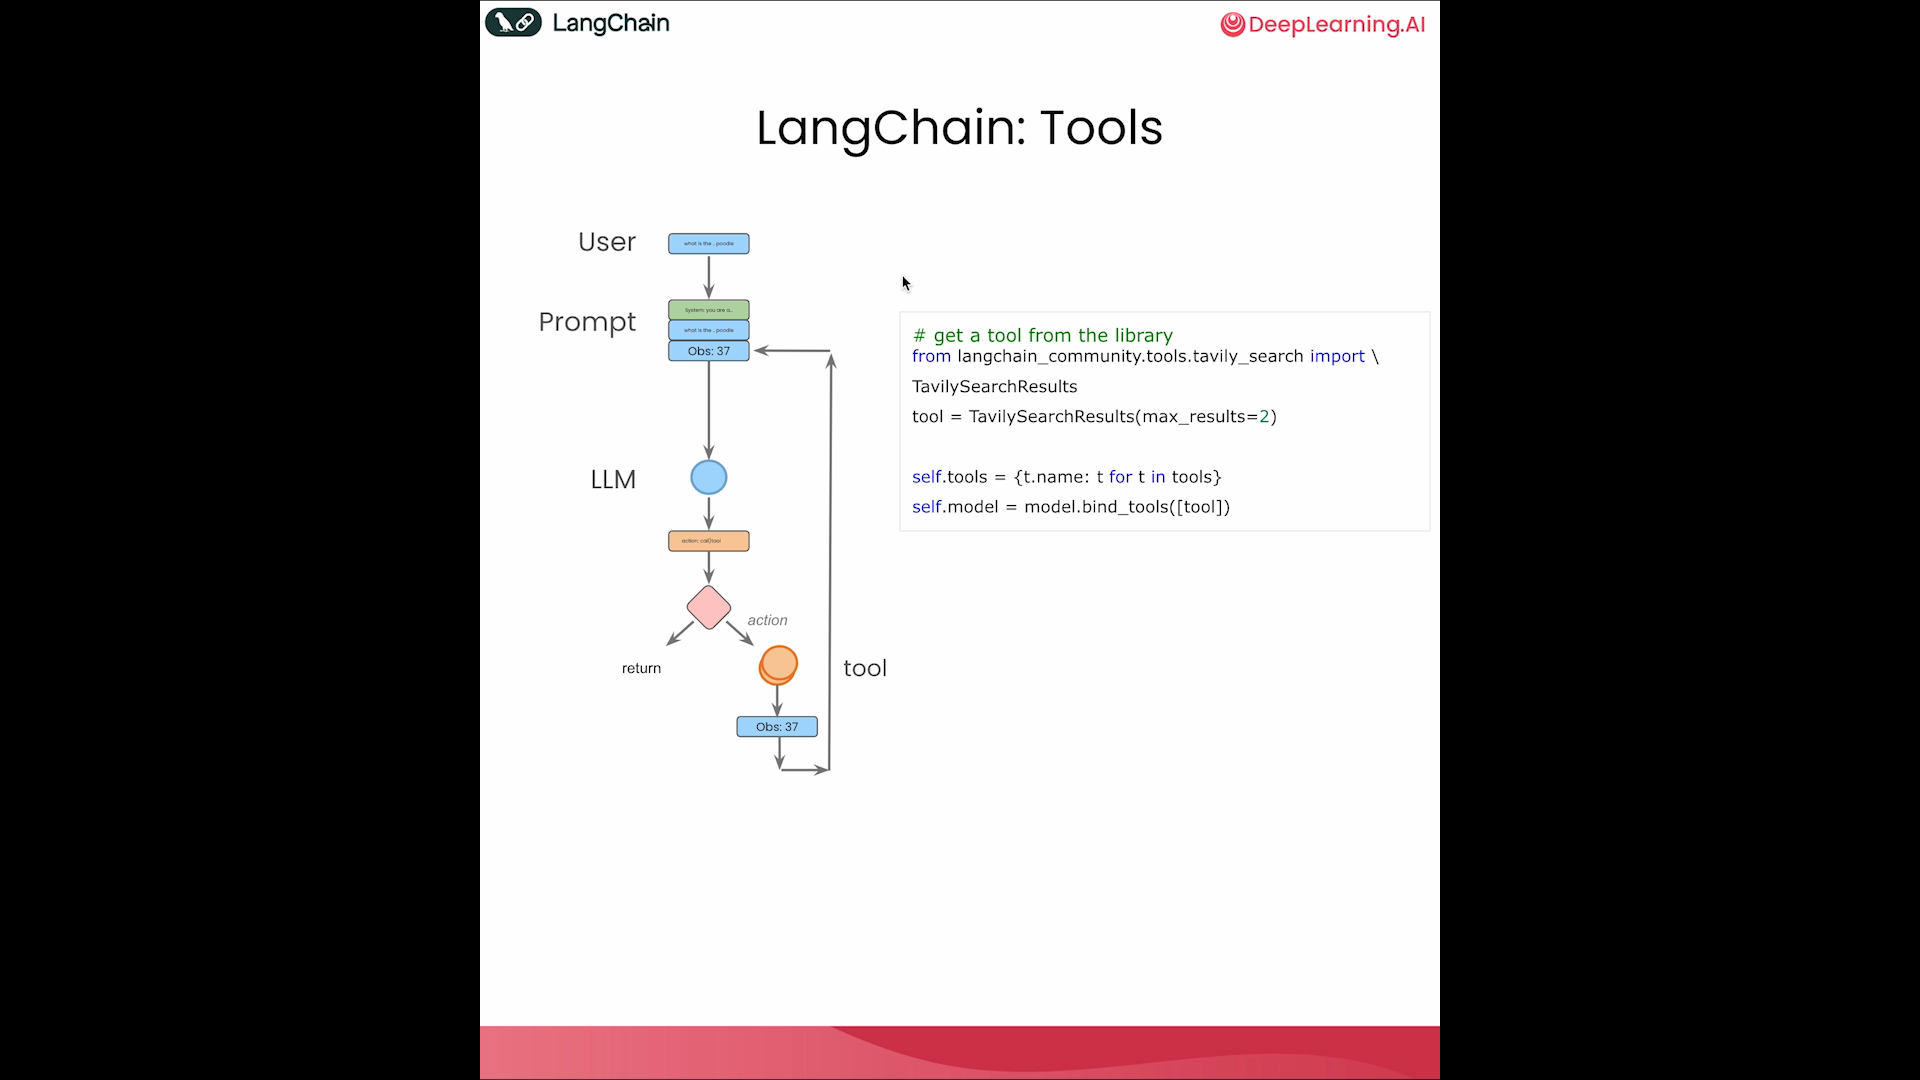

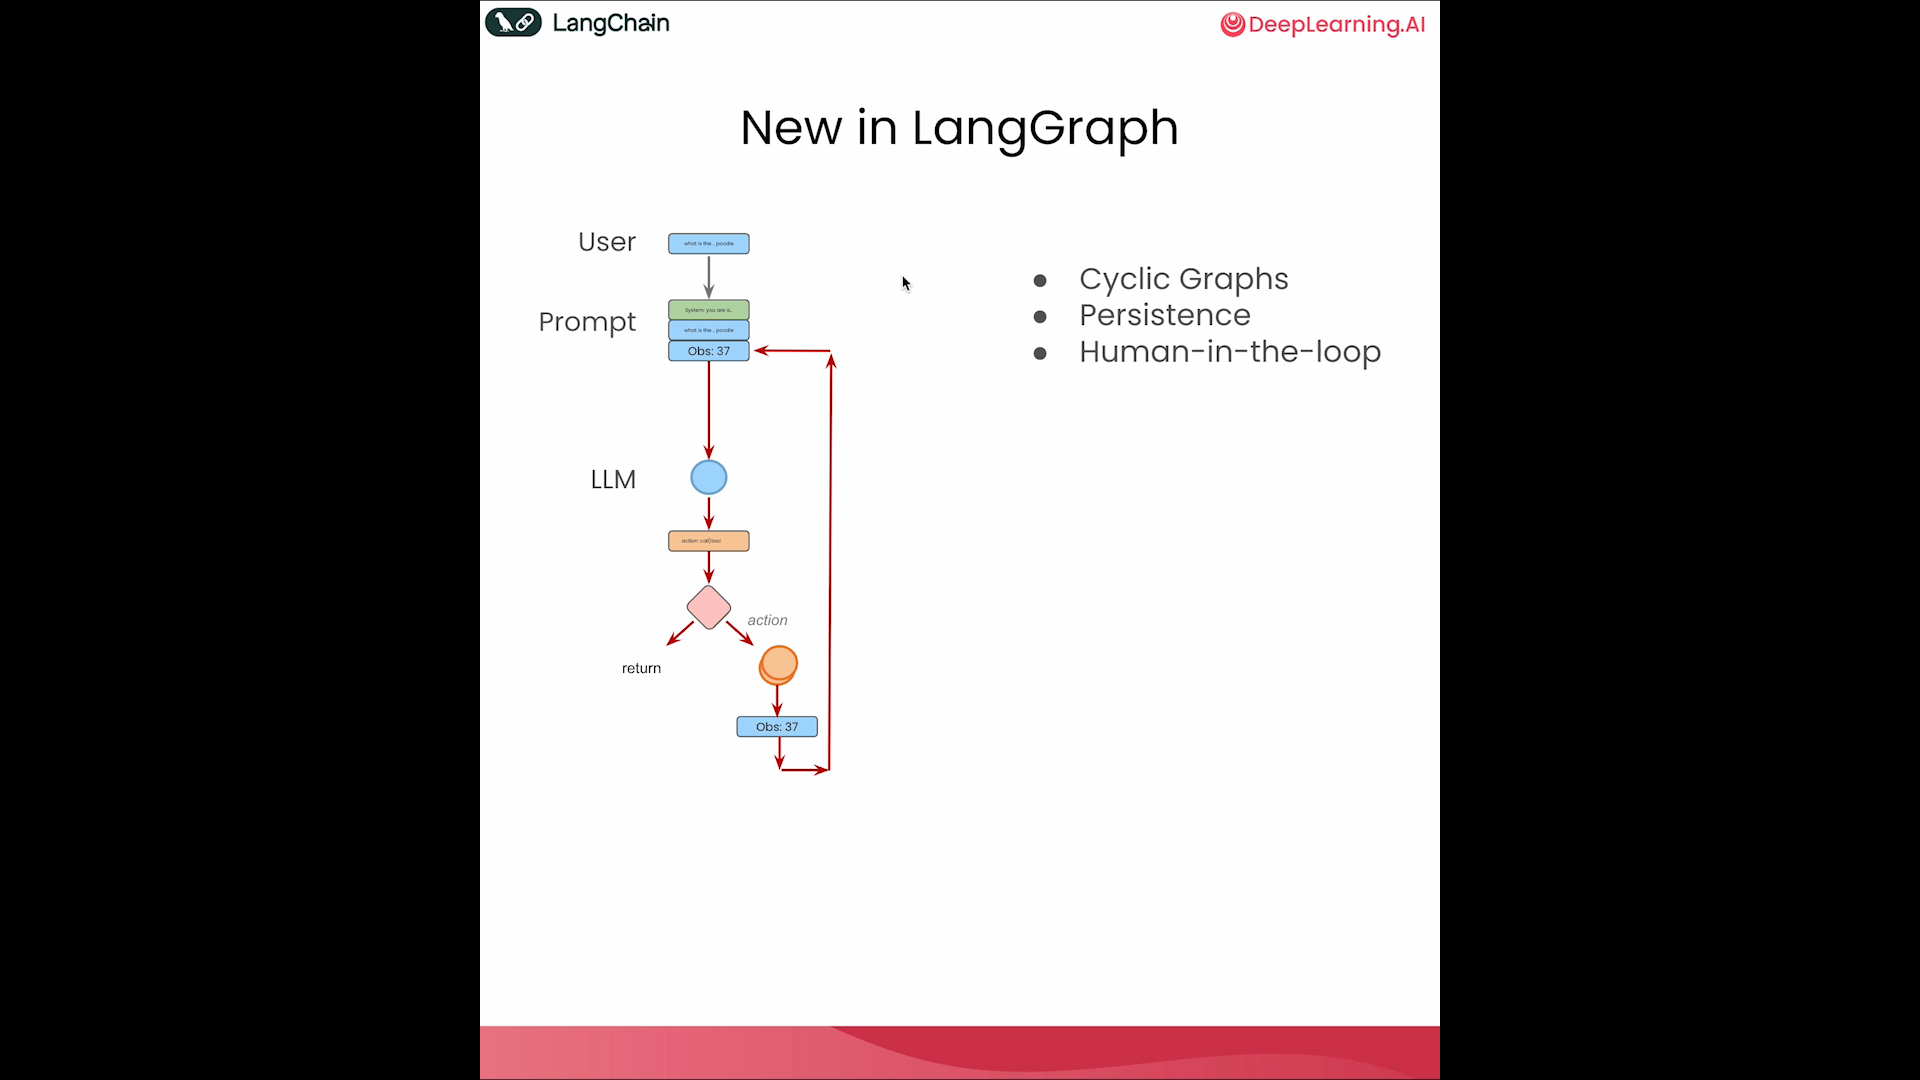

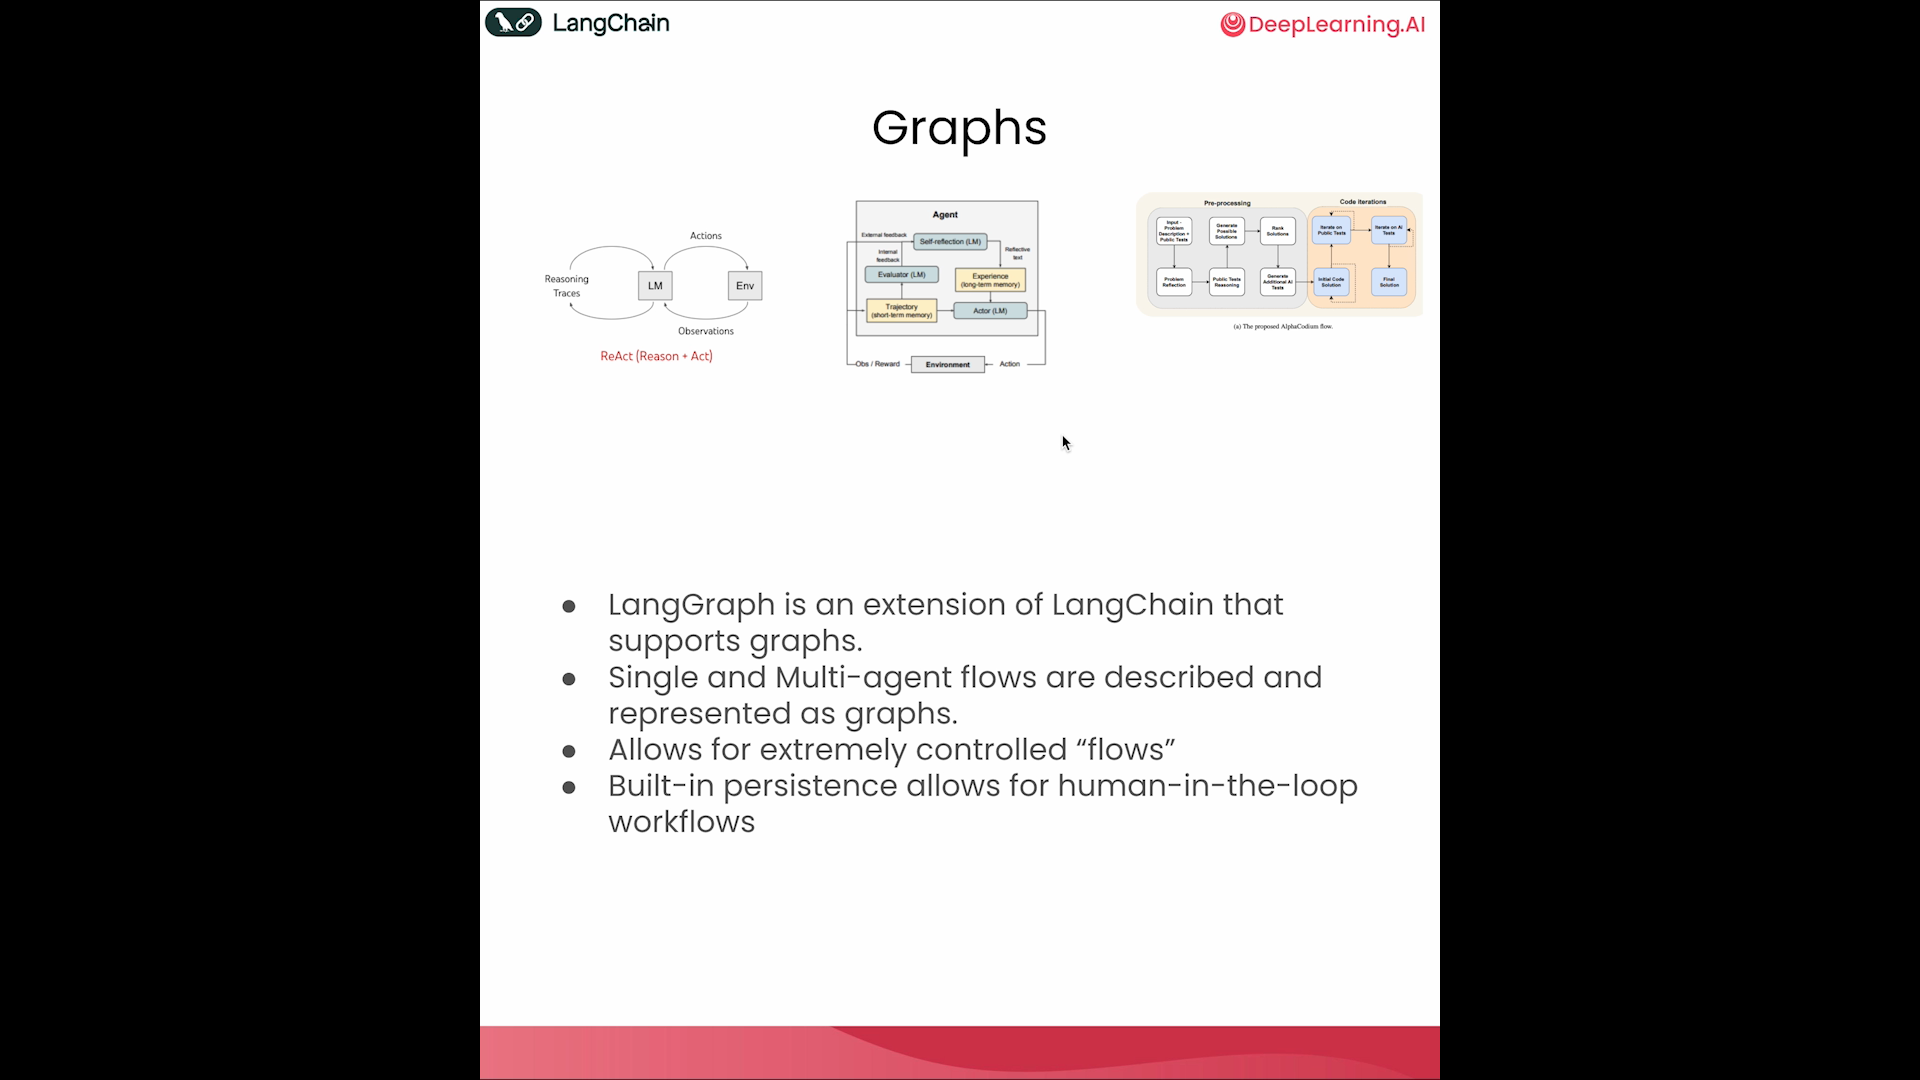

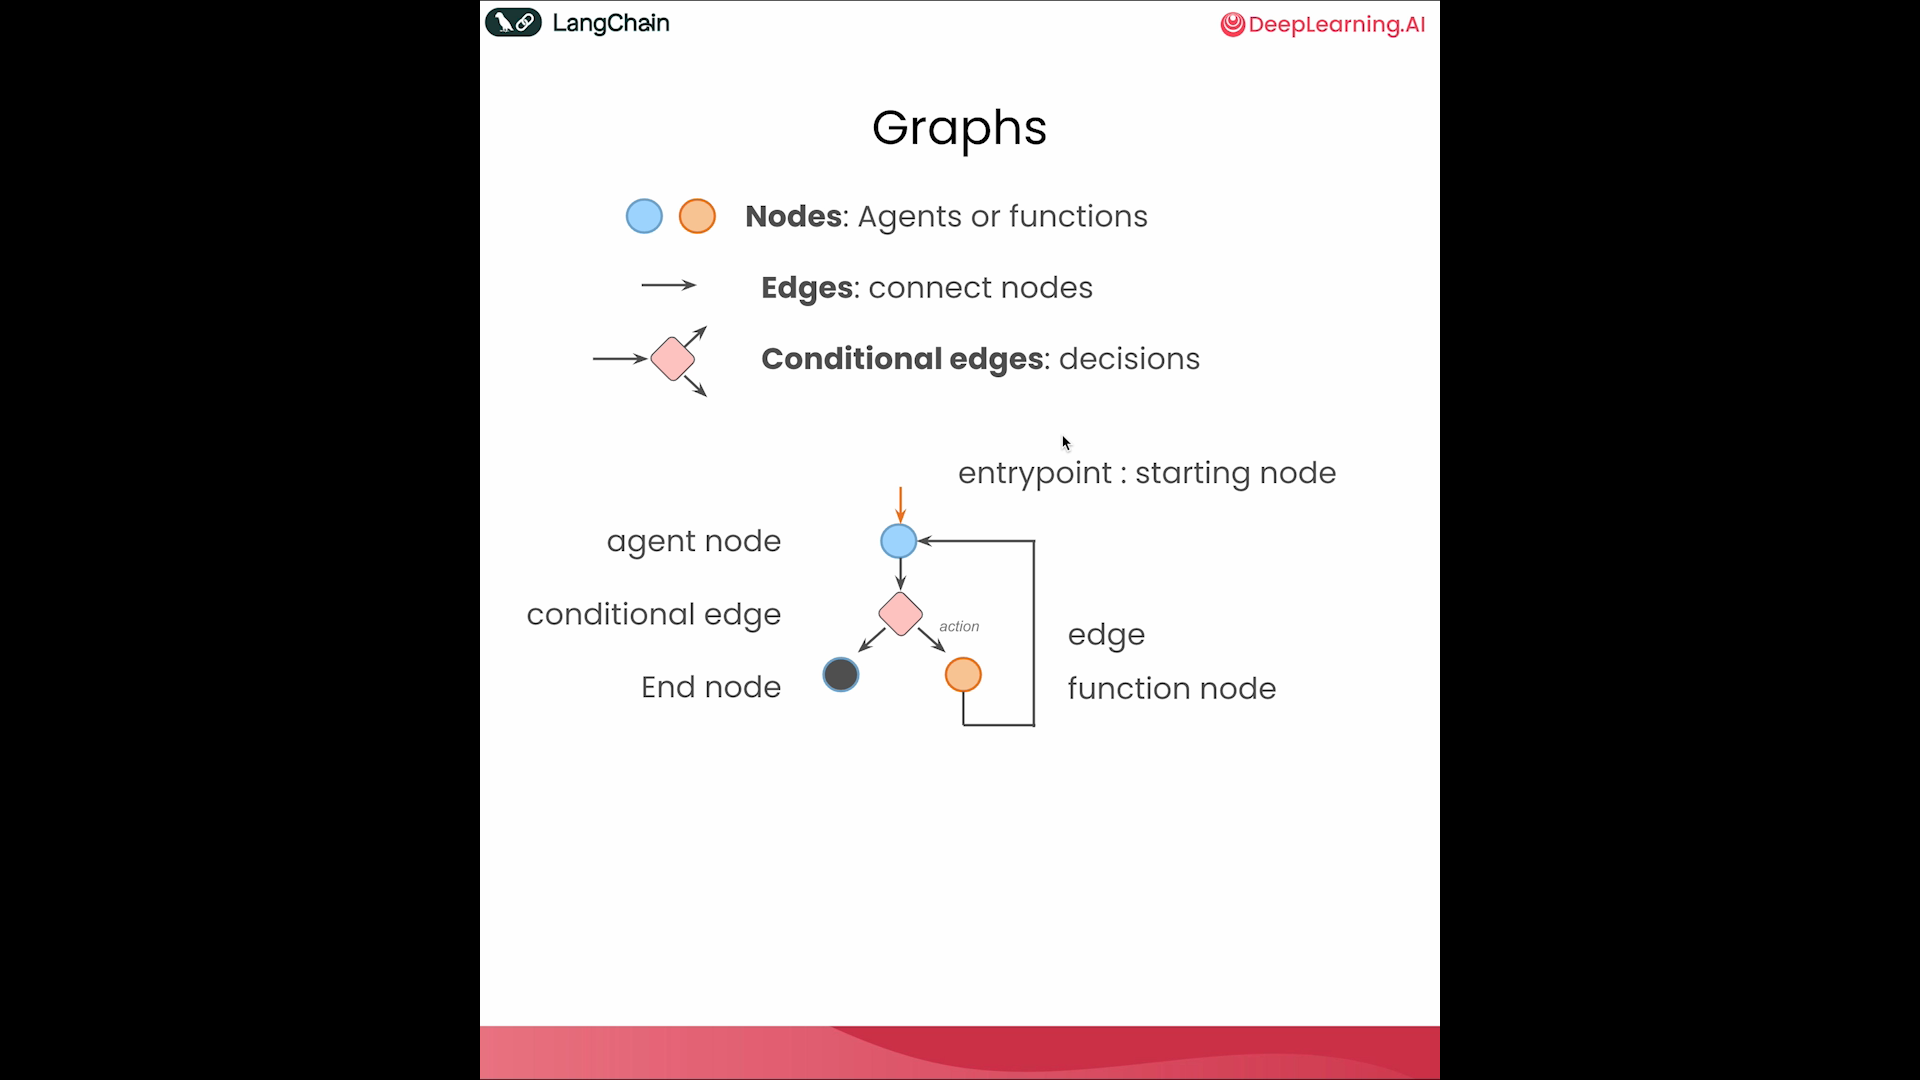

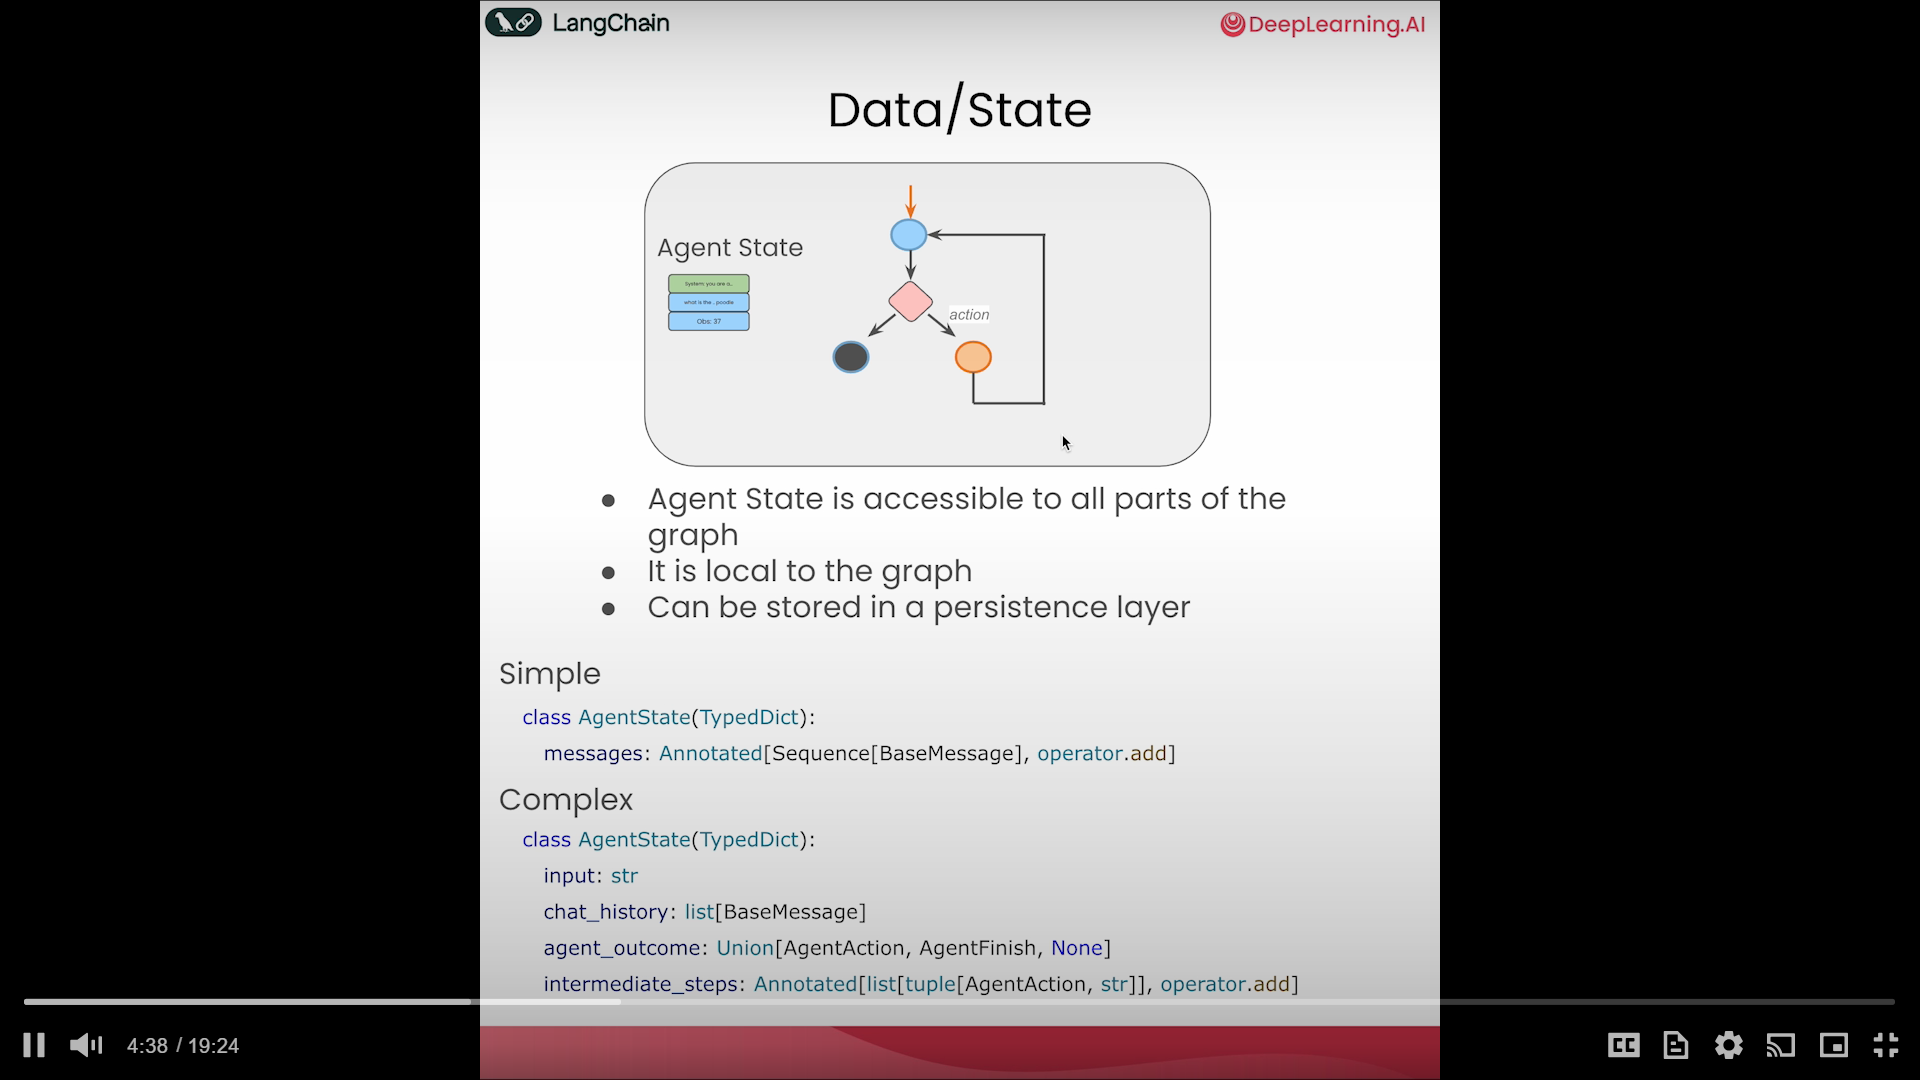

In above state , When Annotated is not used , Means it overwrite the existing state . And intermediate steps is annotated with add .Means it adds 

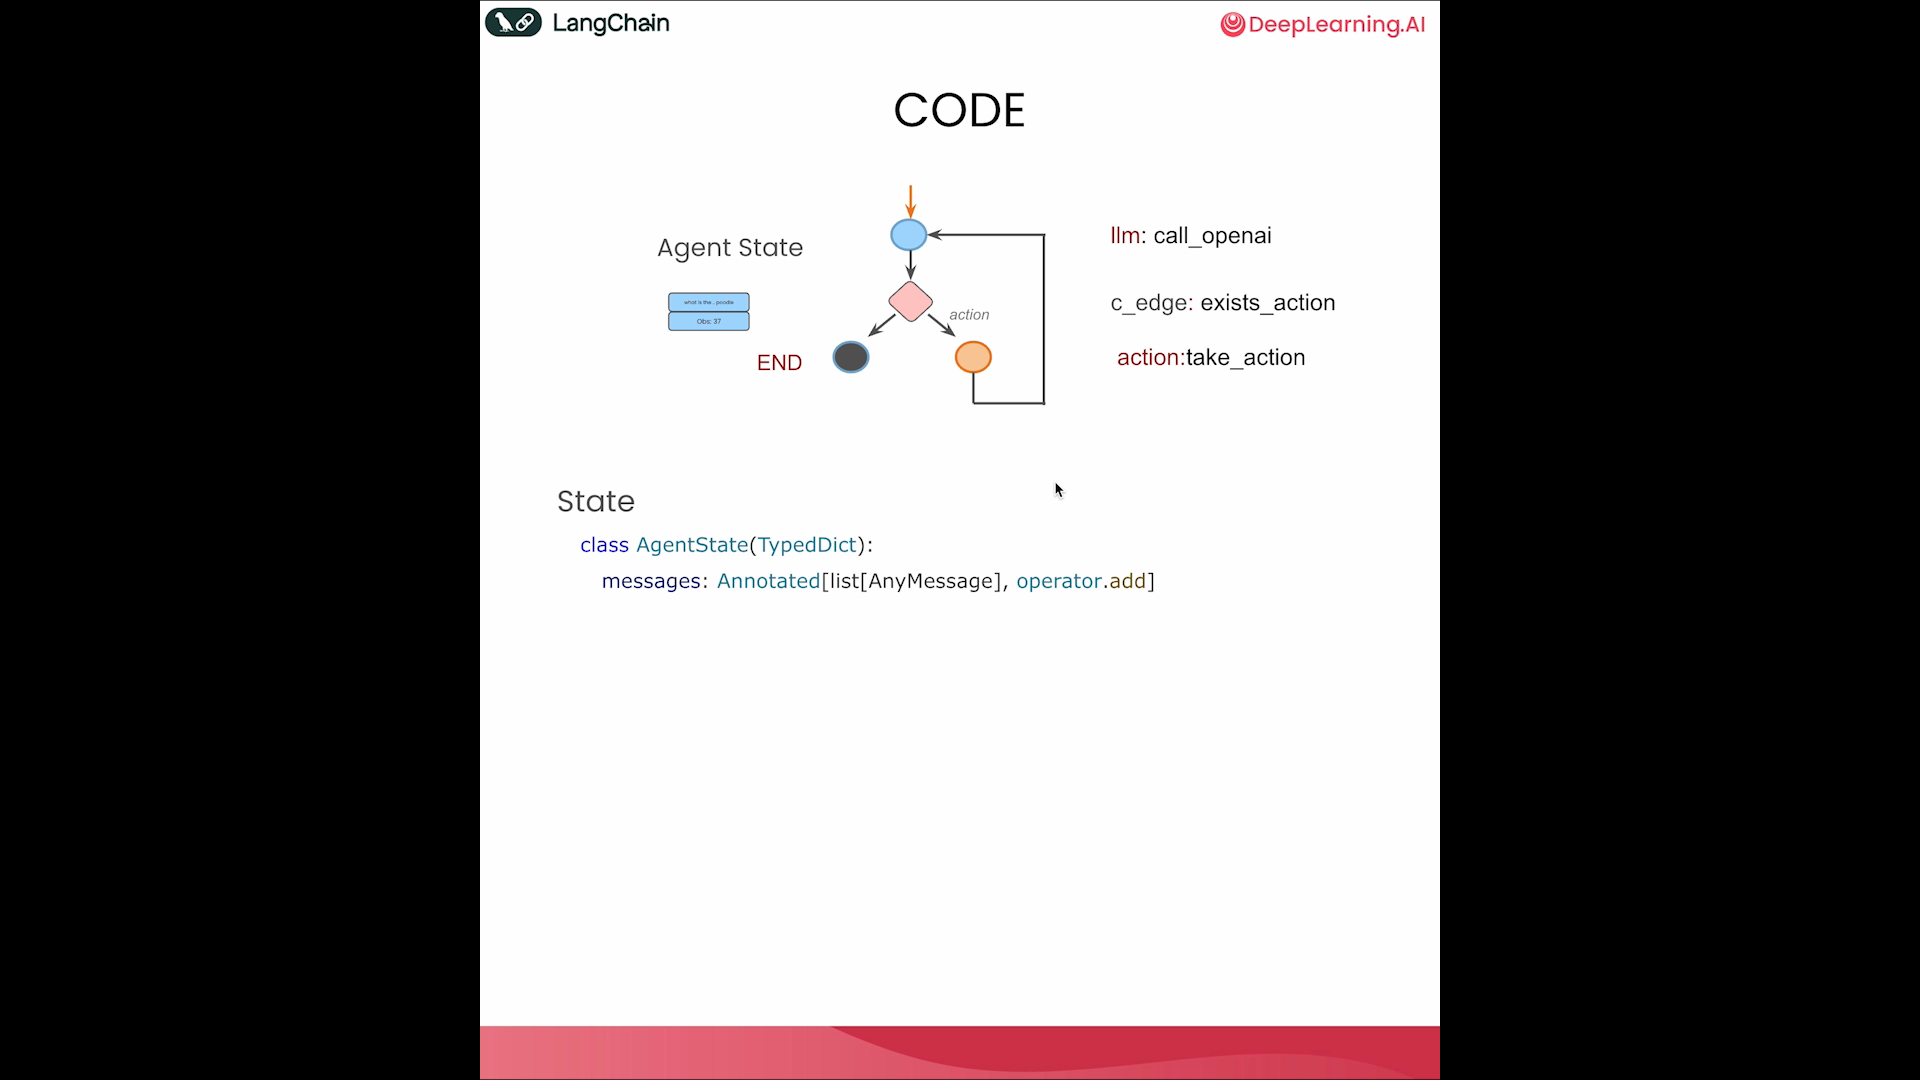

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END  ### End is End node in graph 
from typing import TypedDict, Annotated ## Used to construct agent state
import operator ## Used to contruct agent state 
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage ## Different message types
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    ### Annotate list of messages will be added overtime
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        ### i/p - model to use , tools to call and system message
        self.system = system
        graph = StateGraph(AgentState)
        ## Create 2 nodes and 1 edge
        graph.add_node("llm", self.call_openai) ## Function Representing LLM Node 
        graph.add_node("action", self.take_action) ## Function Representing Action Node 
        graph.add_conditional_edges( ### Function return True if there is any action
            "llm", ## Node where edge starts
            self.exists_action, ## Action Function
            {True: "action", False: END} ## If above function returns true , We will go to action node or else go to end node
        )
        ### Regular edge
        graph.add_edge("action", "llm") ### start,end
        graph.set_entry_point("llm") 
        self.graph = graph.compile()   ### Calling and invoking the graph
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)  ### Its letting the model know that it has tool available to call whenever needed

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}  ### Result will get added to the AgentState and it will not overwrite it 

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls  ### Identify tool calls name 
        results = []
        for t in tool_calls:
            print(f"Calling: {t}") 
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args']) ## call tool
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

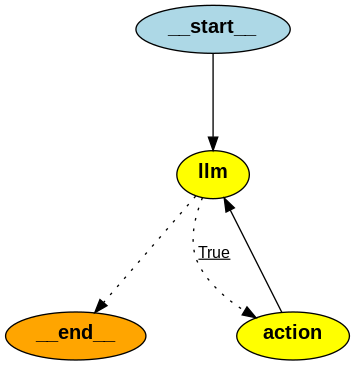

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_W4jjes0YLpRY4rke4OkcBN9c'}
Back to the model!


In [9]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_W4jjes0YLpRY4rke4OkcBN9c', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b96c7617-28b0-4d81-8ecb-b53df346cd35-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_W4jjes0YLpRY4rke4OkcBN9c'}]),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 17

In [10]:
result['messages'][-1].content

'The current weather in San Francisco is 57.1°F with clear skies. The wind is blowing at 13.3 kph from WSW, and the humidity is at 81%.'

In [11]:
messages = [HumanMessage(content="What is the weather in SF and LA?")] ## Functions are called in parallel.Because before print back to model it called both functions
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_WjffYWt5jeJsrCHjetQOsMuT'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_lyyx65Ysot4FKIGUvd7xzbzl'}
Back to the model!


In [13]:
result['messages'][-1].content

'The current weather in San Francisco is clear, with a forecast of mostly clear and partly cloudy conditions for the next few hours. The temperature is expected to be in the mid-50s to mid-60s Fahrenheit.\n\nIn Los Angeles, the current weather is clear with a temperature of 78.4°F. The forecast predicts clear conditions with temperatures around the high 70s to low 80s Fahrenheit.'

In [16]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages}) ## It sequentially calling the functions . Becaouse o/p of 1 is i/p to another

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Super Bowl in 2024?'}, 'id': 'call_jVRbVg9IbSrbiiCQ3DT7aQFR'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs team headquarters location'}, 'id': 'call_b5tsxxb1a5qXhtXby21OxWSU'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_ffFLJ48dNMMJwoeO59nMAM47'}
Back to the model!


In [17]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs are headquartered in Kansas City, Missouri.

3. **What is the GDP of that state?**
   - The GDP of Missouri was approximately $397 billion as of the most recent data available.
